In [1]:
import sys
sys.path.append("../code/")
from common import APPLIANCES_ORDER




In [2]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
tensor = np.load('../1H-input.npy')

In [4]:
def create_subset_dataset(tensor):
    t_subset = tensor[:, :, 180:194, :]
    all_indices = np.array(list(range(320)))
    for i in range(1, 7):
        valid_homes = pd.DataFrame(t_subset[:, i, :].reshape(320, 14*24)).dropna().index
        all_indices = np.intersect1d(all_indices, valid_homes)
    t_subset = t_subset[all_indices, :, :, :].reshape(52, 7, 14*24)
    
    # Create artificial aggregate
    t_subset[:, 0, :] = 0.0
    for i in range(1, 7):
        t_subset[:, 0, :] = t_subset[:, 0, :] + t_subset[:, i, :]
    # t_subset is of shape (#home, appliance, days*hours)
    return t_subset, all_indices

In [5]:
t_all, valid_homes = create_subset_dataset(tensor)
t_all.shape

(52, 7, 336)

In [6]:
t_all.shape

(52, 7, 336)

In [7]:
def my_objective(y_pred, y_true):
    with tf.name_scope(None):
        return tf.losses.absolute_difference(y_pred, y_true)

In [8]:
from random import randint
from numpy import array
from numpy import argmax
from numpy import array_equal
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
import keras
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
n_movies = 3
n_users=3
n_latent_factors=2

Using TensorFlow backend.
/Users/nipun/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [9]:
APPLIANCES_ORDER

['aggregate', 'hvac', 'fridge', 'mw', 'dw', 'wm', 'oven']

In [10]:
train_agg = t_all[:30, 0, :].reshape(30*14, 24)
train_appliance = {}
test_appliance = {}
for appliance_num, appliance in enumerate(APPLIANCES_ORDER[1:]):
    train_appliance[appliance] = t_all[:30, appliance_num+1, :].reshape(30*14, 24)
    test_appliance[appliance] = t_all[30:, appliance_num+1, :].reshape(22*14, 24)






test_hvac = t_all[30:, 1, :].reshape(22*14, 24)
test_fridge = t_all[30:, 2, :].reshape(22*14, 24)

test_mw = t_all[30:, 3, :].reshape(22*14, 24)



test_agg = t_all[30:, 0, :].reshape(22*14, 24)

In [30]:
train_appliance[appliance].max(axis=1)

0       50.549999
1      124.449997
2       39.433334
3       44.033333
4       44.133335
5       73.349998
6       39.283333
7       45.566666
8       75.349998
9       46.416668
10     257.750000
11      39.066666
12      45.400002
13      39.116665
14     113.183334
15     161.733337
16     168.366669
17     136.566666
18     173.383331
19     153.716660
20     167.566666
21     147.283340
22     173.050003
23     209.383331
24     225.699997
25     154.416672
26      57.016666
27      96.733330
28       6.800000
29      94.349998
          ...    
390      3.016667
391      3.000000
392     49.833332
393     35.466667
394     35.533333
395     49.900002
396     41.916668
397     18.783333
398     35.766666
399     25.283333
400     61.750000
401     18.583334
402      4.000000
403     65.583336
404     19.000000
405     38.916668
406    115.150002
407     95.216667
408     83.566666
409     81.300003
410     84.183334
411     83.400002
412     52.766666
413    130.383331
414    138

In [32]:
x = train_appliance[appliance].max(axis=1)
weights = np.ones(train_appliance[appliance].shape[0])

weights[x>50]=1.
weights[x<50]=0.1
weights.shape

(420,)

In [144]:
from keras.layers import Reshape

pred_appliance = {}
num_iterations_dictionary = {'hvac':1200,'fridge':500,'mw':250,'dw':250,'oven':250, 'wm':300}
for appliance in APPLIANCES_ORDER[4:5]:
    print(appliance)
    print("*"*20)
    np.random.seed(0)
    from keras.layers.merge import Subtract, Minimum
    from keras import regularizers
    agg_input = keras.layers.Input(shape=[24],name='Aggregate')
    appliance_dense_1 = keras.layers.Dense(units=20,name='Appliance-layer-1',activation='relu')(agg_input)
    #appliance_bn = keras.layers.BatchNormalization()(appliance_dense_1)
    dropout = keras.layers.Dropout(rate=0.1,name='Droput-Appliance')(appliance_dense_1)




    out = keras.layers.Dense(units=24,name='Appliance-output',activation='relu')(dropout)
    out = Minimum(name='Clip-to-agg')([out, agg_input])
    out = Reshape(target_shape=(24,1))(out)


    model = keras.Model(agg_input, out)
    model.compile('adam','mean_absolute_error',sample_weight_mode="temporal")
    x = train_appliance[appliance]
    weights = np.ones_like(x)

    weights[x>100]=10.
    weights[x<100]=0.3
    model.fit(train_agg, train_appliance[appliance].reshape(-1,24,1), epochs=num_iterations_dictionary[appliance],
              validation_split=0.1, sample_weight=weights)
    pred_appliance[appliance] = model.predict(test_agg).reshape(-1,24)



dw
********************
Train on 378 samples, validate on 42 samples
Epoch 1/250
378/378 [==============================] - 1s 2ms/step - loss: 174.9087 - val_loss: 217.3571
Epoch 2/250
378/378 [==============================] - 0s 60us/step - loss: 158.9539 - val_loss: 191.2717
Epoch 3/250
378/378 [==============================] - 0s 52us/step - loss: 145.3181 - val_loss: 174.2093
Epoch 4/250
378/378 [==============================] - 0s 54us/step - loss: 136.5517 - val_loss: 167.9083
Epoch 5/250
378/378 [==============================] - 0s 53us/step - loss: 128.7447 - val_loss: 162.2084
Epoch 6/250
378/378 [==============================] - 0s 53us/step - loss: 126.5620 - val_loss: 155.8831
Epoch 7/250
378/378 [==============================] - 0s 57us/step - loss: 123.0938 - val_loss: 150.4940
Epoch 8/250
378/378 [==============================] - 0s 53us/step - loss: 125.0515 - val_loss: 147.2604
Epoch 9/250
378/378 [==============================] - 0s 52us/step - loss: 119.0525

378/378 [==============================] - 0s 63us/step - loss: 89.3435 - val_loss: 137.4956
Epoch 78/250
378/378 [==============================] - 0s 68us/step - loss: 86.1383 - val_loss: 136.7612
Epoch 79/250
378/378 [==============================] - ETA: 0s - loss: 116.117 - 0s 63us/step - loss: 88.6243 - val_loss: 138.2083
Epoch 80/250
378/378 [==============================] - 0s 64us/step - loss: 86.6984 - val_loss: 139.3518
Epoch 81/250
378/378 [==============================] - 0s 66us/step - loss: 89.4775 - val_loss: 137.3178
Epoch 82/250
378/378 [==============================] - 0s 66us/step - loss: 85.1031 - val_loss: 137.9883
Epoch 83/250
378/378 [==============================] - 0s 57us/step - loss: 86.0724 - val_loss: 138.9626
Epoch 84/250
378/378 [==============================] - 0s 48us/step - loss: 89.7320 - val_loss: 138.0934
Epoch 85/250
378/378 [==============================] - 0s 55us/step - loss: 89.9681 - val_loss: 136.7540
Epoch 86/250
378/378 [===========

378/378 [==============================] - 0s 66us/step - loss: 83.0710 - val_loss: 137.3402
Epoch 154/250
378/378 [==============================] - 0s 57us/step - loss: 78.9107 - val_loss: 136.9286
Epoch 155/250
378/378 [==============================] - 0s 65us/step - loss: 78.1320 - val_loss: 137.2320
Epoch 156/250
378/378 [==============================] - 0s 58us/step - loss: 80.5391 - val_loss: 136.7792
Epoch 157/250
378/378 [==============================] - 0s 65us/step - loss: 77.7740 - val_loss: 136.7405
Epoch 158/250
378/378 [==============================] - 0s 56us/step - loss: 78.8954 - val_loss: 136.1043
Epoch 159/250
378/378 [==============================] - 0s 59us/step - loss: 80.9471 - val_loss: 137.0389
Epoch 160/250
378/378 [==============================] - 0s 55us/step - loss: 76.3978 - val_loss: 136.5105
Epoch 161/250
378/378 [==============================] - 0s 53us/step - loss: 80.2107 - val_loss: 136.1129
Epoch 162/250
378/378 [============================

378/378 [==============================] - 0s 56us/step - loss: 71.3293 - val_loss: 135.0508
Epoch 230/250
378/378 [==============================] - 0s 53us/step - loss: 73.7765 - val_loss: 135.5634
Epoch 231/250
378/378 [==============================] - 0s 52us/step - loss: 71.0954 - val_loss: 134.0683
Epoch 232/250
378/378 [==============================] - 0s 52us/step - loss: 75.3892 - val_loss: 134.8660
Epoch 233/250
378/378 [==============================] - 0s 51us/step - loss: 73.3955 - val_loss: 135.4790
Epoch 234/250
378/378 [==============================] - 0s 59us/step - loss: 71.0189 - val_loss: 136.5997
Epoch 235/250
378/378 [==============================] - 0s 56us/step - loss: 73.3433 - val_loss: 134.8119
Epoch 236/250
378/378 [==============================] - 0s 65us/step - loss: 70.8742 - val_loss: 134.6960
Epoch 237/250
378/378 [==============================] - 0s 60us/step - loss: 73.1608 - val_loss: 134.4555
Epoch 238/250
378/378 [============================

In [111]:
with open('per-appliance.pdf','wb') as f:
    f.write(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='pdf'))



In [145]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Aggregate (InputLayer)          (None, 24)           0                                            
__________________________________________________________________________________________________
Appliance-layer-1 (Dense)       (None, 20)           500         Aggregate[0][0]                  
__________________________________________________________________________________________________
Droput-Appliance (Dropout)      (None, 20)           0           Appliance-layer-1[0][0]          
__________________________________________________________________________________________________
Appliance-output (Dense)        (None, 24)           504         Droput-Appliance[0][0]           
__________________________________________________________________________________________________
Clip-to-ag

In [146]:
from sklearn.metrics import mean_absolute_error
mae = {}
for appliance in APPLIANCES_ORDER[1:]:
    try:
        mae[appliance] = mean_absolute_error(test_appliance[appliance], pred_appliance[appliance])
    except Exception as e:
        print(e)
    
    

'hvac'
'fridge'
'mw'
'wm'
'oven'


In [147]:
pd.Series(mae)

dw    48.21602
dtype: float64

In [140]:
pd.Series(mae)

dw    14.499389
dtype: float64

In [134]:
pred_hvac.shape

(308, 24, 1)

In [105]:
pred_hvac = model.predict(test_agg)


from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(pred_hvac, test_fridge))
print(mean_absolute_error(pred_hvac, test_agg))




ValueError: Found array with dim 3. Estimator expected <= 2.

In [106]:
(pd.DataFrame(pred_hvac) - pd.DataFrame(test_agg)).max()

ValueError: Must pass 2-d input

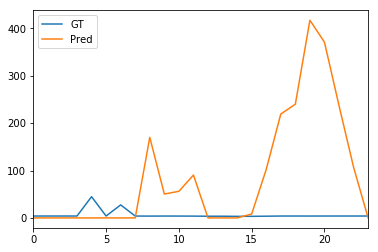

In [148]:
pd.Series(test_mw[5, :]).plot(label='GT')
#pd.Series(test_agg[1, :]).plot(label='GT')


pd.Series(pred_appliance['dw'][5]).plot(label='Pred')




plt.legend()

In [118]:
pd.Series(pred_appliance['dw'].max(axis=1)).describe()

count    308.000000
mean      33.767479
std       50.790043
min        0.000000
25%        2.650855
50%       13.080427
75%       39.675549
max      386.673706
dtype: float64